<font size = 6>National instrument USB-6002 DAQ example</font>

In [1]:
# write and read from the FSM and compare with LabVIEW vi
import nidaqmx
import numpy as np
from collections import deque
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from scipy.optimize import curve_fit
from skimage import data
from skimage.feature import match_template

from LowLevelModules.NIdaq import *
from LowLevelModules.NIdaqAPD import *

from LowLevelModules.GeneralFunctions import *

from collections import deque
import time

def lorentziansin(x,  amp, cen, fwhm, bkg, asin,fsin,phisin):
    return amp / (1+   ( 2*(x-cen)/fwhm )**2   ) + asin*np.sin(2*np.pi*fsin*x+phisin) +bkg

def line(x,  a, b):
    return a*x+b

In [2]:
time.sleep(1)

In [2]:
def acquire_one_voltage():
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan('/Dev2/ai0', 'USB ai0')
        
        curr_v = task.read()
    return curr_v

def acquire_one_diff_voltage():
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan('/Dev2/ai2', 'USB ai0',terminal_config=nidaqmx.constants.TerminalConfiguration.DIFFERENTIAL)
        curr_v = task.read()
    return curr_v

def acquire_at_rate(rate,npnts):
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan('/Dev2/ai0', 'USB ai0')
        task.timing.cfg_samp_clk_timing(rate= rate, 
                                        active_edge=nidaqmx.constants.Edge.RISING ,
                                        sample_mode= nidaqmx.constants.AcquisitionType.FINITE, 
                                        samps_per_chan=npnts)   
#         self.triggers.start_trigger.cfg_dig_edge_start_trig(trig_src,nidaqmx.constants.Edge.FALLING  )
        
        task.start()
        aiv=task.read(number_of_samples_per_channel=npnts)
    return aiv

def generate_one_voltage(v):
    with nidaqmx.Task() as task:
        task.ao_channels.add_ao_voltage_chan('/Dev2/ao1', 'USB ao1', min_val=-5, max_val=5)
        task.write(v)
        task.wait_until_done(timeout=5)
        
def generate_many_voltage(varray,rate):
    with nidaqmx.Task() as task:
        npnts=len(varray)
        task.ao_channels.add_ao_voltage_chan('/Dev2/ao1', 'USB ao1')
        task.timing.cfg_samp_clk_timing(rate= rate, 
                                active_edge=nidaqmx.constants.Edge.RISING ,
                                sample_mode= nidaqmx.constants.AcquisitionType.FINITE, 
                                samps_per_chan=npnts)
#         task.triggers.start_trigger.cfg_dig_edge_start_trig(trig_src,nidaqmx.constants.Edge.RISING)        
        task.write(varray, auto_start=True, timeout=5)
#         task.start()
        task.wait_until_done(timeout=5)

acquire_one_diff_voltage()
acquire_one_voltage()

0.011583362938836217

<IPython.core.display.Javascript object>


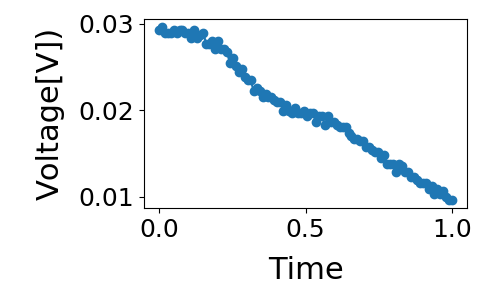

In [7]:
aiv=acquire_at_rate(50000,100)
xx = np.linspace(0,1,100)
lp = LivePlot(1, 1, 5, 3, 'o', 'Time', 'Voltage[V])')
lp.plot_live(xx, aiv)
# plt.plot(aiv)

In [8]:
generate_one_voltage(0)

NameError: name 'generate_one_voltage' is not defined

In [ ]:
# for PLE, need to update voltage one at a time
# we can also to a voltage sweep if need be

In [9]:
generate_many_voltage(varray,1000)
varray=np.sin(np.linspace(0,10,1000))

<font size = 6>Drive laser test
drive from -5 V to +5 V</font>

In [18]:
# output digital high to trigger DG645
DGExtTrigTask = DO('/Dev2/port1/line3')
DGExtTrigTask.write(False)

# update laser piezo control voltage   
LaserTask = AO('/Dev2/ao1')
LaserTask.write(0)
time.sleep(0.1)
LaserTask.write(-2)
# time.sleep(0.1)
DGExtTrigTask.write(True) # around 2 ms delay from laser update to digital signal rising edge

LaserTask.close()
DGExtTrigTask.close()

In [19]:
# calibrate input output
FPTask = AO('/Dev2/ao0')
AITask = AI('/Dev2/ai0')
aoVolt =-0.01
FPTask.write(aoVolt)
time.sleep(0.5)
aiVolt = AITask.read()
print(aiVolt,aiVolt-aoVolt)
FPTask.close()
AITask.close()


0.03510342605295591 0.04510342605295591


<font size=6>Fabry Perot test</font>

In [20]:
# For Fabry-Perot scan, we need to scan and read voltage
# similar to FSM
# generate voltage at a rate
# read voltage at a rate
# both of them are triggered by say PFI0
# with say internally P0.0 connected to PFI1 for internal trigger

# input range is -10 to 10 V, step size 0.3 mV
# need to make sure we have enough light
# also need to terminate input by 1 MOhm or some other well controlled value
# for now, let's 

# say ao0 - FP cavity
# ao1 - laser

# let's use the digital output to drive PFI0 and PFI1 

# output positive voltages
# say with 1 mV step
# 0 to 6 V -> 6001 different values

In [22]:
FPtask=AO('/Dev2/ao0')
FPtask.write(0)
FPtask.wait_until_done()
FPtask.close()

In [23]:
cavityPDtask = AI('/Dev2/ai0')

aiV=cavityPDtask.read()
print(aiV)
cavityPDtask.close()

0.03510342605295591


best_vals: [-2.98984483e-01  3.12102019e+00  1.06407549e-01  2.31889115e-03
  6.23337644e-02  9.97778739e-01  1.51232304e+00]


<IPython.core.display.Javascript object>


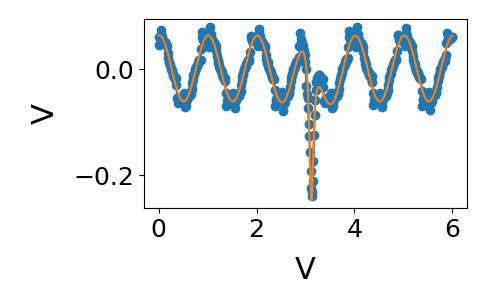

In [8]:
ao_pts = 500
v_final = 6.0
v_ao_scan = np.linspace(0,v_final,ao_pts)
# v_ao_scan[ao_pts-1]=0
ao_scan_rate = 5000
ao_trig_src =  '/Dev2/PFI0'
ai_trig_src =  '/Dev2/PFI1'

t0 = np.linspace(0,ao_pts/ao_scan_rate,ao_pts)

# configure digital channel to output 0
dig_trig = DO('/Dev2/port0/line0')
dig_trig.write(False)

# set up  AO AI
FPtask=AO('/Dev2/ao0')

# FPtask.write(0)
# time.sleep(0.5)

FPtask.config_write(v_ao_scan,ao_scan_rate,ao_trig_src)
# cavityPDtask = AI('/Dev2/ai0',terminal_config=nidaqmx.constants.TerminalConfiguration.DIFFERENTIAL)
cavityPDtask = AI('/Dev2/ai0')
cavityPDtask.config_read_rising(ao_pts,ao_scan_rate,ai_trig_src)
dig_trig.write(True)

FPtask.wait_until_done()
# FPtask.write(0)
FPtask.close()
aiV=cavityPDtask.read(number_of_samples_per_channel=ao_pts)

cavityPDtask.close()

dig_trig.close()

init_vals = [np.amin(aiV), v_ao_scan[np.argmin(aiV)], 0.2, 0.05,1,1,1]  # for [amp, cen, wid]


xinit = max(0,np.argmin(aiV)- int(4.0/v_final*ao_pts))
xfin = min(ao_pts-1,np.argmin(aiV)+int(4.0/v_final*ao_pts))

best_vals, covar = curve_fit(lorentziansin, v_ao_scan[xinit:xfin], aiV[xinit:xfin], p0=init_vals)
print('best_vals: {}'.format(best_vals))

lp = LivePlot(1, 1, 5, 3, 'o', 'V',"V")
lp.plot_live(v_ao_scan,aiV)
plt.plot(v_ao_scan, lorentziansin(v_ao_scan, best_vals[0], best_vals[1],best_vals[2],best_vals[3],best_vals[4],best_vals[5],best_vals[6]),
         label='Fitted function')

# lp2 = LivePlot(1, 1, 5, 3, 'o', 'Time[s]',"V")
# lp2.plot_live(t0,aiV)

FPtask=AO('/Dev2/ao0')
FPtask.write(0)
FPtask.close()
# fig=plt.figure()
# plt.plot(aiV)


In [20]:

init_vals = [np.amin(aiV), v_ao_scan[np.argmin(aiV)], 0.2, 0.05,1,1,1]  # for [amp, cen, wid]
best_vals, covar = curve_fit(lorentziansin, v_ao_scan, aiV, p0=init_vals)
print('best_vals: {}'.format(best_vals))


v_ao_scan[np.argmin(aiV)]

np.amin(aiV)

best_vals: [-3.09468211e-01  4.63108776e+00  1.37816649e-01  3.41445303e-03
  3.04613119e-02  1.00017803e+00  3.71187637e-01]


-0.3086761265876703

<IPython.core.display.Javascript object>


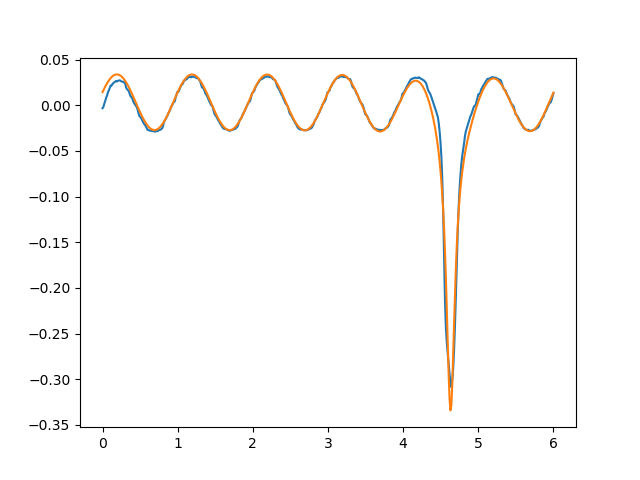

In [16]:
plt.figure()
plt.plot(v_ao_scan,aiV)
plt.plot(v_ao_scan, lorentziansin(v_ao_scan, best_vals[0], best_vals[1],best_vals[2],best_vals[3],best_vals[4],best_vals[5],best_vals[6]),
         label='Fitted function')

In [13]:
a =np.linspace(0,6,int(ao_pts/2)  ) 
b = np.linspace(6,0,int(ao_pts/2)  ) 
v_ao_scan = np.concatenate((a,b),axis=None)


<font size = 6> Single FP scan</font>

In [4]:
def FP_scan():
    """
    Fabry Perot scan
    scan only, no fitting or plotting
    always go back to 0
    """
    ao_pts_half = 250
    v_final = 6.0
    a = np.linspace(0,v_final,ao_pts_half) 
    b = np.linspace(v_final,0,ao_pts_half) 
    v_ao_scan = np.concatenate((a,b),axis=None)
    ao_pts = ao_pts_half*2

    ao_scan_rate = 5000
    ao_trig_src =  '/Dev2/PFI0'
    ai_trig_src =  '/Dev2/PFI1'

    # time
    t0 = np.linspace(0,(ao_pts-1)/ao_scan_rate,ao_pts)

    dig_trig = DO('/Dev2/port0/line0')    
    dig_trig.write(False)

    # set up  AO AI
    FPtask=AO('/Dev2/ao0')
    cavityPDtask = AI('/Dev2/ai0')

    FPtask.config_write(v_ao_scan,ao_scan_rate,ao_trig_src)
    cavityPDtask.config_read_rising(ao_pts,ao_scan_rate,ai_trig_src)

    # start FP scan
    dig_trig.write(True)
    FPtask.wait_until_done()
    aiV = cavityPDtask.read(number_of_samples_per_channel=ao_pts)

    FPtask.close()
    cavityPDtask.close()   
    dig_trig.write(False)
    dig_trig.close()
    return t0,v_ao_scan,aiV

def FP_fit(tarray,piezo, PD):
    """
    fit a lorentzian + sine to the input
    assume piezo is either linearly increasing or decreasing
    
    """
    npts = len(piezo)
    vrange = np.amax(piezo)-np.amin(piezo)
    scan_rate = 1/(tarray[1]-tarray[0])
    init_vals = [np.amin(PD), piezo[np.argmin(PD)], 0.2, 0.05,0.1,60*npts/scan_rate/vrange,1]
    best_vals, covar = curve_fit(lorentziansin, piezo, PD, p0=init_vals)
    return best_vals

Time taken (s) = 0.13000774383544922


<IPython.core.display.Javascript object>


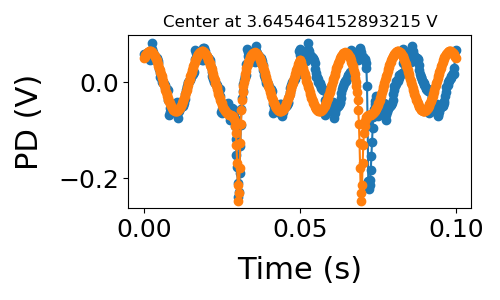

In [84]:
# do a single scan and plot output
tinit = time.time()
t0_this,v_ao_scan_this,aiV_this = FP_scan()
tfin = time.time()
print(f'Time taken (s) = {tfin-tinit}')
best_vals = FP_fit(t0_this[0:249],v_ao_scan_this[0:249], aiV_this[0:249])
lp = LivePlot(1, 2, 5, 3, 'o', 'Time (s)',"PD (V)")
yfit = lorentziansin(v_ao_scan_this, best_vals[0], best_vals[1],best_vals[2],best_vals[3],best_vals[4],best_vals[5],best_vals[6])
lp.plot_live(t0_this,aiV_this,yfit)
plt.title(f'Center at {best_vals[1]} V')
plt.tight_layout()

<font size=6>Simplified continuous FP scan</font>

<IPython.core.display.Javascript object>


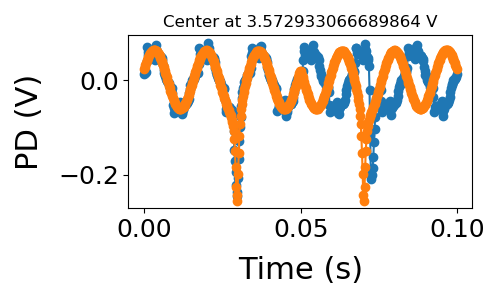

In [42]:
lp = LivePlot(1, 2, 5, 3, 'o', 'Time (s)',"PD (V)")
while True:
    try:
        t0_this,v_ao_scan_this,aiV_this = FP_scan()
        best_vals = FP_fit(t0_this[0:249],v_ao_scan_this[0:249], aiV_this[0:249])
        yfit = lorentziansin(v_ao_scan_this, best_vals[0], best_vals[1],best_vals[2],best_vals[3],best_vals[4],best_vals[5],best_vals[6])
        lp.plot_live(t0_this,aiV_this,yfit)
        plt.title(f'Center at {best_vals[1]} V')
        plt.tight_layout()
        time.sleep(1)
    except:
        break
        

<font size=6>Continuous Fabry-Perot scan</font>

<IPython.core.display.Javascript object>


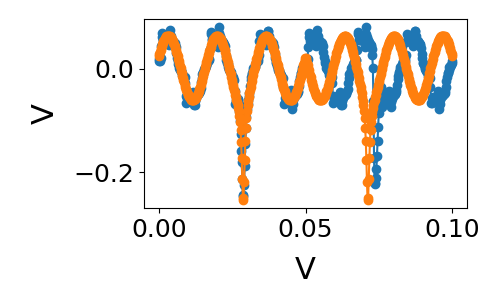

In [3]:
# continuous scan
ao_pts = 500
v_final= 6.0
a =np.linspace(0,v_final,int(ao_pts/2)  ) 
b = np.linspace(v_final,0,int(ao_pts/2)  ) 
v_ao_scan = np.concatenate((a,b),axis=None)
ao_pts = int(ao_pts/2) + int(ao_pts/2)

# v_ao_down_scan = np.linspace(6,0,ao_pts)

ao_scan_rate = 5000
ao_trig_src =  '/Dev2/PFI0'
ai_trig_src =  '/Dev2/PFI1'

# time
t0 = np.linspace(0,ao_pts/ao_scan_rate,ao_pts)

dig_trig = DO('/Dev2/port0/line0')

lp = LivePlot(1, 2, 5, 3, 'o', 'V',"V")
while True: 
    try:
        dig_trig.write(False)

        # set up  AO AI
        FPtask=AO('/Dev2/ao0')
        cavityPDtask = AI('/Dev2/ai0')

        FPtask.config_write(v_ao_scan,ao_scan_rate,ao_trig_src)
        cavityPDtask.config_read_rising(ao_pts,ao_scan_rate,ai_trig_src)
        
        # start FP scan
        dig_trig.write(True)
        FPtask.wait_until_done()
        aiV = cavityPDtask.read(number_of_samples_per_channel=ao_pts)

        init_vals = [np.amin(aiV[0:int(ao_pts/2)-1]), v_ao_scan[np.argmin(aiV[0:int(ao_pts/2)-1])], 0.2, 0.05,0.1,60*ao_pts/2/ao_scan_rate/v_final,1]  # for [amp, cen, wid]
        best_vals, covar = curve_fit(lorentziansin, v_ao_scan[0:int(ao_pts/2)-1], aiV[0:int(ao_pts/2)-1], p0=init_vals)
#         print('best_vals: {}'.format(best_vals))
#         print(best_vals[1])

        yfit = lorentziansin(v_ao_scan, best_vals[0], best_vals[1],best_vals[2],best_vals[3],best_vals[4],best_vals[5],best_vals[6])
        lp.plot_live(t0,aiV,yfit)
#         plt.plot(v_ao_scan, yfit,       label='Fitted function')
#         lp2.plot_live(t0,aiV)
        FPtask.close()
        cavityPDtask.close()
#         dig_trig.write(False)
        
#         FPtask=AO('/Dev2/ao0')
#         FPtask.config_write(v_ao_downscan,ao_scan_rate,ao_trig_src)
#         dig_trig.write(True)
#         FPtask.wait_until_done()
#         FPtask.close()
#         dig_trig.close()
        time.sleep(1)
    except:
        # press the stop button to trigger this
#         FPtask.write(0)
#         FPtask.close()
#         cavityPDtask.close()
        dig_trig.close()
        break        
        
# lp = LivePlot(1, 1, 5, 3, 'o', 'V',"V")
# lp.plot_live(v_ao_scan,aiV)


# lp2 = LivePlot(1, 1, 5, 3, 'o', 'Time[s]',"V")
# lp2.plot_live(t0,aiV)

# FPtask=AO('/Dev2/ao0')
# FPtask.write(0)
# FPtask.close()
# fig=plt.figure()
# plt.plot(aiV)


0.001200240048009602


<IPython.core.display.Javascript object>


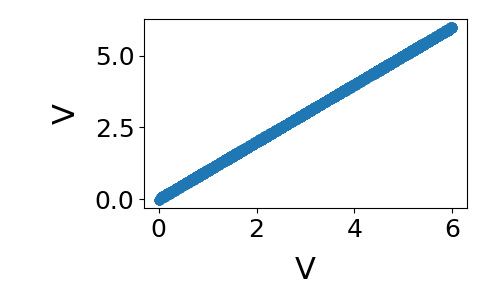

In [25]:
print(v_ao_scan[1])
v_diff=v_ao_scan-aiV
v_diff[0]=np.nan

lp2 = LivePlot(1, 1, 5, 3, 'o', 'V',"V")
lp2.plot_live(v_ao_scan,v_diff)

In [8]:
ao_pts = 5000
v_ao_scan = np.linspace(0,6,ao_pts)
ao_scan_rate = 5000
ao_trig_src =  '/Dev2/PFI0'
ai_trig_src =  '/Dev2/PFI1'

# configure digital channel to output 0
dig_trig = DO('/Dev2/port0/line0')
dig_trig.write(False)

# set up  AO AI
FPtask=AO('/Dev2/ao0')

FPtask.write(0)
time.sleep(0.5)

FPtask.config_write(v_ao_scan,ao_scan_rate,ao_trig_src)
cavityPDtask = AI('/Dev2/ai0')
cavityPDtask.config_read_rising(ao_pts,ao_scan_rate,ai_trig_src)
dig_trig.write(True)

FPtask.wait_until_done()
FPtask.close()
aiV=cavityPDtask.read(number_of_samples_per_channel=ao_pts)

cavityPDtask.close()

dig_trig.close()

lp = LivePlot(1, 1, 5, 3, 'o', 'V',"V")
lp.plot_live(v_ao_scan,aiV)

# fig=plt.figure()
# plt.plot(aiV)


In [3]:

FPtask.close()

cavityPDtask.close()

dig_trig.close()

c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\nidaqmx\task.py:463: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<392>" but task was already closed.
  'already closed.'.format(self._saved_name), DaqResourceWarning)
c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\nidaqmx\task.py:463: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<391>" but task was already closed.
  'already closed.'.format(self._saved_name), DaqResourceWarning)
c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\nidaqmx\task.py:463: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<38F>" but task was already closed.
  'already closed.'.format(self._saved_name), DaqResourceWarning)


In [24]:
FPtask.close()

In [24]:
FPtask=AO('/Dev2/ao0')
# FPtask.config_write(v_ao_scan,ao_scan_rate,ao_trig_src)
cavityPDtask = AI('/Dev2/ai0')

In [60]:
FPtask.write(-5)

cavityPDtask.read()


-5.03298688607174

In [53]:
a=cavityPDtask.read()

In [42]:
vreadlist[0]=2

In [75]:
FPtask.write(-5)

1

In [76]:
FPtask.write(-5)
time.sleep(2)
vlist= np.linspace(-5,5,100)

vreadlist = np.zeros(100)
for ind,v in enumerate(vlist):
    FPtask.write(v)
    FPtask.wait_until_done()
    time.sleep(0.05)
    vreadlist[ind]=cavityPDtask.read()
#     print(ind,vreadlist[ind])


<IPython.core.display.Javascript object>


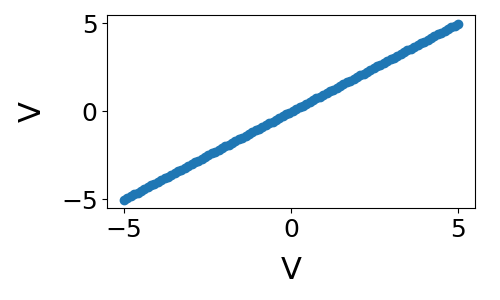

In [77]:
lp3 = LivePlot(1, 1, 5, 3, 'o', 'V',"V")
lp3.plot_live(vlist,vreadlist)

In [72]:
v_diff = vlist-vreadlist

<IPython.core.display.Javascript object>


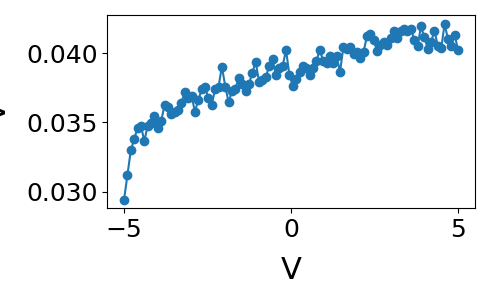

In [78]:
lp4 = LivePlot(1, 1, 5, 3, 'o', 'V',"V")
lp4.plot_live(vlist,v_diff)